# HealthKart – Weekly Growth Accounting Analysis

This notebook analyzes weekly active user data to compute growth accounting metrics
(New, Retained, Resurrected, Churned, WAU, and Quick Ratio) and derive product insights.

## 1. Data Loading and Exploration

In [4]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\DELL\Desktop\Active Users Data - Internship Round 1 Assignment Healthkart - Active Users.csv"
)

df.head()


,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w51,w52,w53,w54,w55,w56,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59
0,fd7c28f9fd8045f2,fd7c28f9fd8045f2,fd7c28f9fd8045f2,fd7c28f9fd8045f2,fd7c28f9fd8045f2,231d91be38352d7a,306243851b716bf6,149f7dd1efe25ebc,191a909000d7123d,191a909000d7123d,...,ffedb2a5b3b4838,ffedb2a5b3b4838,ffedb2a5b3b4838,fffe76c3a948cdfb,fffe76c3a948cdfb,fffe76c3a948cdfb,NaN,NaN,NaN,2.0
1,6.73E+14,5ff4cd01b5eae601,1402081a023d5c18,45b649baf6882a4a,c92f828ffdd1c1c0,7c8de50e4a84f1ee,eff8ecf5cb54ffe7,b50740442eb78a75,e85d8cc04adae6cc,cf8dfdbbb526c506,...,bc1a7fed50193f41,bb1e4d0008cbabf,bb2e76bb3174a0be,bd0228ee50f09d79,bb4370c7306bb336,b81f04d72ef2e150,NaN,NaN,NaN,2.0
2,1.56E+22,7cd4b3218dbffa0b,99acf0df83dc2831,49740201a5f203eb,8cf94ff315895955,58453f722733b72e,7ec2e98a1613db6c,20e2a9da9c0146ee,fbeb97ecc066639,42aabbe8fa2b258a,...,a7292f3d0d80985b,a5d5d8560d64b95a,a7914920e3ef2b55,a95f016d03945e5c,a6e99e4acd1701d6,a3c2066710a6d65,NaN,NaN,NaN,2.0
3,10156b703e26c334,25167a08527132ac,4820782b3cb8f570,ae16cc7b72fcee52,ecaa9c1913ef2f65,e02ecf94fd8ee5c8,1aba368c76311ef3,49b64be1edab128c,6dff050c07b69b4e,b6be357ac8671a1f,...,9eef01de4af7d619,9d6d4be4eab27e4b,a01148c9b12f3c15,a29b81926b57d967,9f5835c16ef759bb,9af6497cd753b9b9,NaN,NaN,NaN,2.0
4,103f96126c333035,7fbf03c17ea12589,d8aaa5b13424da35,bd26c51dd185a3cb,6028ea4b2b053007,b5c3d0e920ed6175,fa45dfe1357d3db9,b9928cbdfb35c1,d6a7f937733dea7,b7a452cfbee2d008,...,d7f6ec45f8815d98,d6ec98374c4a453,d7415d7979ce86d9,d84e5dc003ef9155,d851694a086bfc17,d63515fbe6484033,NaN,NaN,NaN,2.0


**Dataset Overview:**
- Total rows: 4,014
- Total weeks: 56 (w1 to w56)
- Format: Each column represents a week, each row contains device IDs active in that week

In [5]:
df.shape


(4014, 60)

In [6]:
df.columns


Index(['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11',
       'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21',
       'w22', 'w23', 'w24', 'w25', 'w26', 'w27', 'w28', 'w29', 'w30', 'w31',
       'w32', 'w33', 'w34', 'w35', 'w36', 'w37', 'w38', 'w39', 'w40', 'w41',
       'w42', 'w43', 'w44', 'w45', 'w46', 'w47', 'w48', 'w49', 'w50', 'w51',
       'w52', 'w53', 'w54', 'w55', 'w56', 'Unnamed: 56', 'Unnamed: 57',
       'Unnamed: 58', 'Unnamed: 59'],
      dtype='object')

## 2. Data Cleaning and Transformation

In [7]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


In [8]:
df_long = (
    df
    .melt(var_name="week", value_name="device_id")
    .dropna()
)


In [9]:
df_long.head()


,week,device_id
0,w1,fd7c28f9fd8045f2
1,w1,6.73E+14
2,w1,1.56E+22
3,w1,10156b703e26c334
4,w1,103f96126c333035


In [10]:
df_long["week_num"] = df_long["week"].str[1:].astype(int)


In [11]:
df_long[["week", "week_num"]].drop_duplicates().sort_values("week_num").head()


,week,week_num
0,w1,1
4014,w2,2
8028,w3,3
12042,w4,4
16056,w5,5


In [12]:
df_long = df_long.sort_values(["device_id", "week_num"])


## 3. User Status Classification

**Definitions:**
- **New Users**: First-time appearance in the dataset
- **Retained Users**: Active this week AND last week (consecutive)
- **Resurrected Users**: Active this week but NOT last week (but was active before)
- **Churned Users**: Active last week but NOT this week

In [13]:
df_long["prev_week_active"] = (
    df_long
    .groupby("device_id")["week_num"]
    .diff()
    .eq(1)
    .fillna(False)
)


In [14]:
df_long["ever_active_before"] = (
    df_long
    .groupby("device_id")
    .cumcount()
    .gt(0)
)


In [15]:
def user_status(row):
    if not row["ever_active_before"]:
        return "New"
    elif row["prev_week_active"]:
        return "Retained"
    else:
        return "Resurrected"

df_long["user_status"] = df_long.apply(user_status, axis=1)


In [16]:
df_long["user_status"].value_counts()


user_status
Retained       122467
New             31824
Resurrected     18090
Name: count, dtype: int64

In [17]:
df_long[df_long["device_id"] == df_long["device_id"].iloc[0]]


,week,device_id,week_num,prev_week_active,ever_active_before,user_status
160060,w40,004d8b2af206bfa2,40,False,False,New


## 4. Weekly Growth Accounting Calculations

In [18]:
weekly = (
    df_long
    .groupby(["week_num", "user_status"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values("week_num")
)


In [19]:
weekly.head()


user_status,week_num,New,Resurrected,Retained
0,1,1759,0,0
1,2,723,0,931
2,3,645,87,1000
3,4,722,225,1169
4,5,674,125,1394


In [20]:
weekly["WAU"] = weekly[["New", "Retained", "Resurrected"]].sum(axis=1)


In [21]:
weekly["Churned"] = weekly["WAU"].shift(1) - weekly["Retained"]
weekly["Churned"] = weekly["Churned"].fillna(0)


In [22]:
weekly["Quick_Ratio"] = (
    (weekly["New"] + weekly["Resurrected"]) / weekly["Churned"]
)

weekly["Quick_Ratio"] = weekly["Quick_Ratio"].replace([float("inf")], None)


In [23]:
weekly.describe()


user_status,week_num,New,Resurrected,Retained,WAU,Churned
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,28.500000,568.285714,323.035714,2186.910714,3078.232143,825.321429
std,16.309506,245.028734,122.641231,532.480517,557.438949,202.511244
min,1.000000,175.000000,0.000000,0.000000,1654.000000,0.000000
25%,14.750000,437.000000,268.000000,2058.500000,2839.000000,720.000000
50%,28.500000,532.000000,309.500000,2284.500000,3095.000000,823.500000
75%,42.250000,647.500000,379.500000,2449.000000,3481.750000,984.500000
max,56.000000,1759.000000,634.000000,2825.000000,4014.000000,1269.000000


In [24]:
weekly.head(10)


user_status,week_num,New,Resurrected,Retained,WAU,Churned,Quick_Ratio
0,1,1759,0,0,1759,0.0,None
1,2,723,0,931,1654,828.0,0.873188
2,3,645,87,1000,1732,654.0,1.119266
3,4,722,225,1169,2116,563.0,1.68206
4,5,674,125,1394,2193,722.0,1.106648
5,6,489,189,1479,2157,714.0,0.94958
6,7,860,204,1487,2551,670.0,1.58806
7,8,1005,193,1677,2875,874.0,1.370709
8,9,719,237,1839,2795,1036.0,0.92278
9,10,621,262,1938,2821,857.0,1.030338


In [25]:
weekly.to_csv("Weekly_Growth_Accounting.csv", index=False)


### Weekly Growth Accounting Visualization

The chart below shows the composition of Weekly Active Users across New, Retained, and Resurrected users.


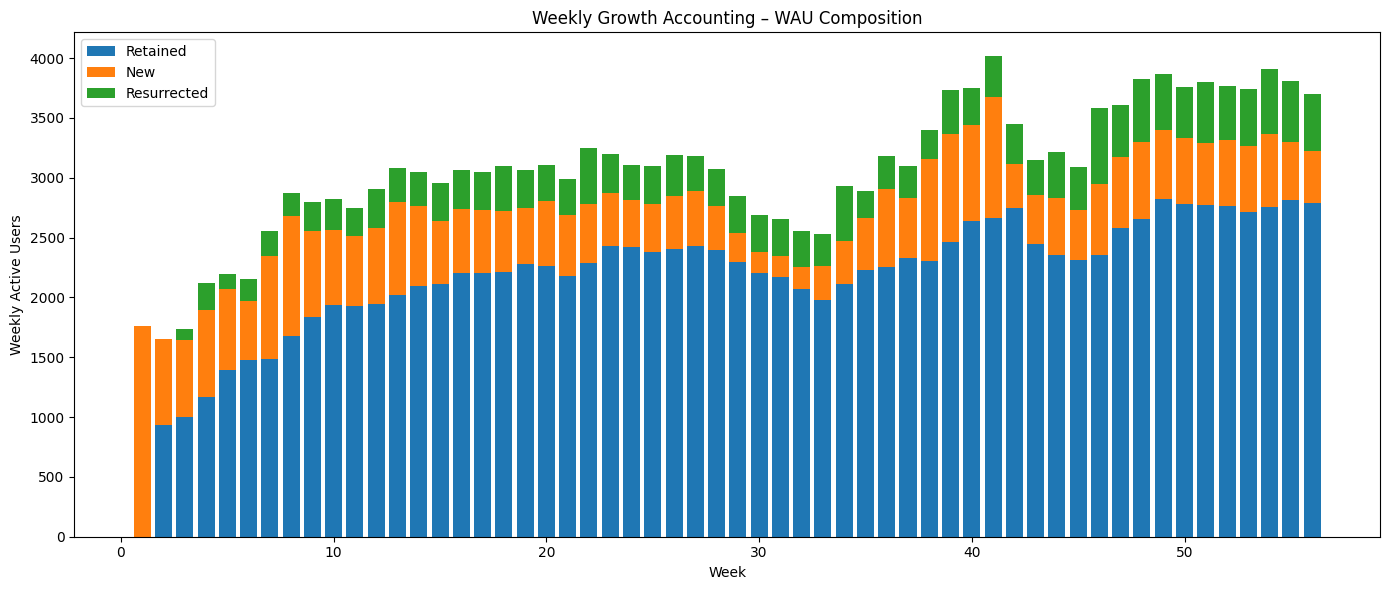

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.bar(
    weekly["week_num"],
    weekly["Retained"],
    label="Retained"
)

plt.bar(
    weekly["week_num"],
    weekly["New"],
    bottom=weekly["Retained"],
    label="New"
)

plt.bar(
    weekly["week_num"],
    weekly["Resurrected"],
    bottom=weekly["Retained"] + weekly["New"],
    label="Resurrected"
)

plt.xlabel("Week")
plt.ylabel("Weekly Active Users")
plt.title("Weekly Growth Accounting – WAU Composition")
plt.legend()
plt.tight_layout()
plt.show()


### Quick Ratio Trend Analysis

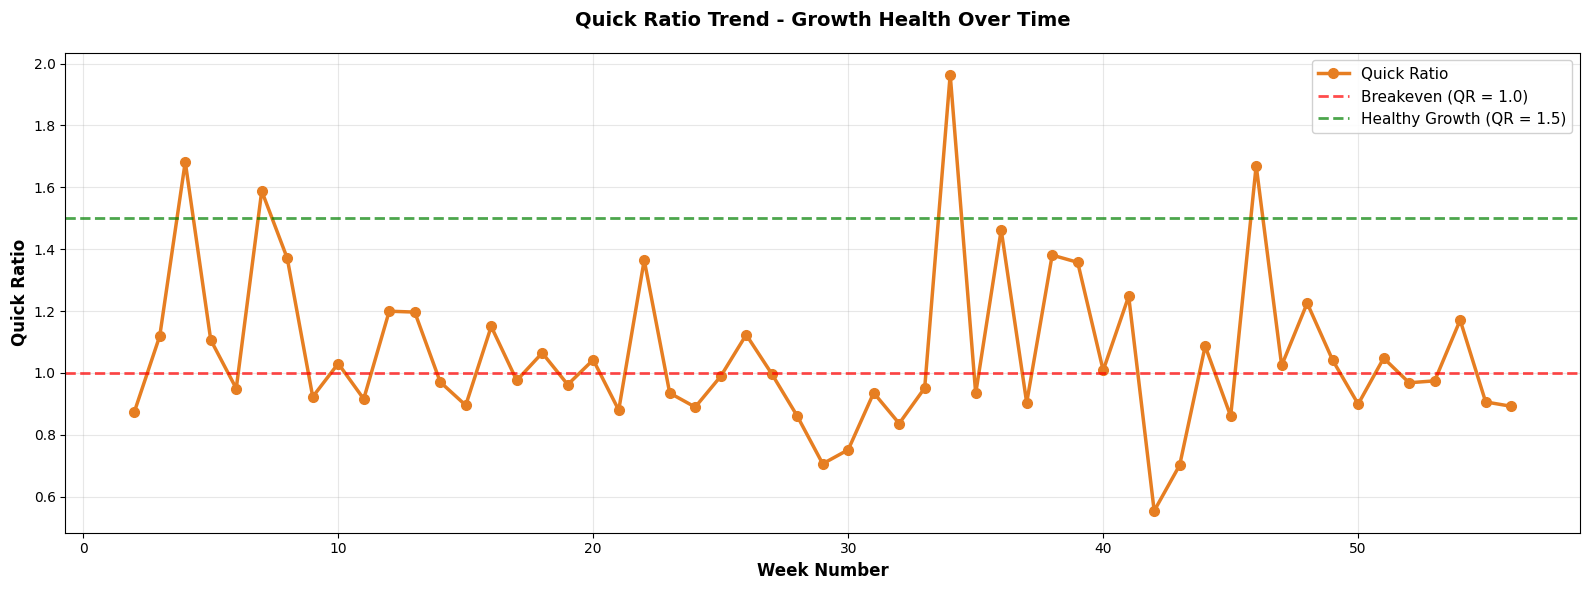

✅ Chart saved as 'Quick_Ratio_Trend.png'


In [27]:

fig, ax = plt.subplots(figsize=(16, 6))


valid_data = weekly[weekly['Quick_Ratio'].notna()]


ax.plot(valid_data['week_num'], valid_data['Quick_Ratio'], 
        marker='o', linewidth=2.5, markersize=7, color='#e67e22', label='Quick Ratio')
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, 
           label='Breakeven (QR = 1.0)', alpha=0.7)
ax.axhline(y=1.5, color='green', linestyle='--', linewidth=2, 
           label='Healthy Growth (QR = 1.5)', alpha=0.7)


ax.set_xlabel('Week Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Quick Ratio', fontsize=12, fontweight='bold')
ax.set_title('Quick Ratio Trend - Growth Health Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Quick_Ratio_Trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart saved as 'Quick_Ratio_Trend.png'")